In [1]:
import pandas as pd
import os
import numpy as np
os.chdir('Module 9 - Order Flow')
import datetime
import scipy.stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Question 1
Apply the BVC method to compute the order flow per minute and plot its value over time. Based only on the last five minutes of the order flow, would you buy or sell ES? (4 pt)

## Answer: 
There seems to be a trend from sell side to the buy side. If following a short term (minutes vs hours) mean reversion strategy, a short position would probably be warranted... If following momentum for the same time horizion, it seems to indicate a signal to go long. 

In [4]:
pv_bar_df = pd.read_csv('ES_continuous_20150828.csv')
pv_bar_df['delta_price'] = pv_bar_df['Close'].diff()
bvc_list = []
for index in list(pv_bar_df.index):
    std = pv_bar_df['delta_price'][:index].std()
    norm = scipy.stats.norm.cdf(((pv_bar_df['Close'].iloc[index] - pv_bar_df['Close'].iloc[index-1]) /std), loc=0, scale=1 )
    bvc_list.append(((2*norm)-1)*pv_bar_df['Volume'].iloc[index])
pv_bar_df['BVC'] = pd.Series(bvc_list)

pv_bar_df.dropna(how='any', inplace=True)
pv_bar_df.style.set_caption("Bar Data")
pv_bar_df.head(10)

,Time,Open,High,Low,Close,Volume,delta_price,BVC
3,2015-08-28 00:03:00,1.943308,1.943308,1.943063,1.943308,100,0.000000,0.000000
4,2015-08-28 00:04:00,1.943308,1.943063,1.942572,1.942572,93,-0.000736,-92.999981
5,2015-08-28 00:05:00,1.942572,1.943063,1.942572,1.942818,92,0.000245,40.139337
6,2015-08-28 00:06:00,1.942818,1.943063,1.942818,1.943063,50,0.000245,22.859877
7,2015-08-28 00:07:00,1.943063,1.943063,1.942818,1.943063,43,0.000000,0.000000
8,2015-08-28 00:08:00,1.943063,1.943308,1.943063,1.943063,16,0.000000,0.000000
9,2015-08-28 00:09:00,1.943063,1.943308,1.942818,1.942818,61,-0.000245,-33.854468
10,2015-08-28 00:10:00,1.942818,1.943063,1.942818,1.942818,58,0.000000,0.000000
11,2015-08-28 00:11:00,1.942818,1.943063,1.942572,1.943063,39,0.000245,23.260917
12,2015-08-28 00:12:00,1.943063,1.943308,1.942818,1.943063,71,0.000000,0.000000


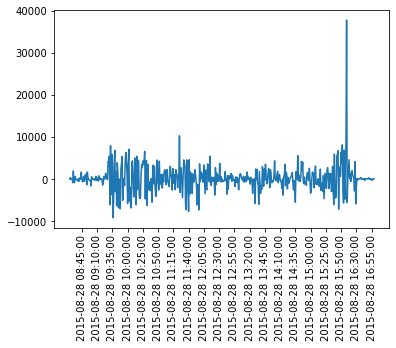

In [5]:
# BVC plotted over final 500 timesteps (about half the data)
timesteps = 500
label_spaces = 25
labels = pv_bar_df['Time'][-timesteps:][pv_bar_df['Time'][-timesteps:].index% label_spaces==0]
plt.plot(pv_bar_df['BVC'][-timesteps:])
plt.xticks(labels.index, labels, rotation=90);

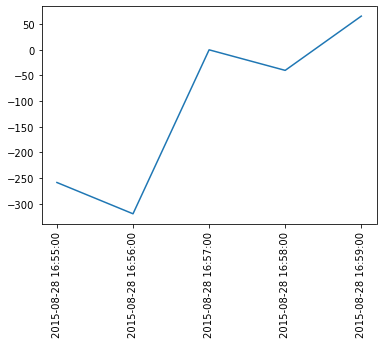

In [6]:
# Last five minutes - apparant trend toward net buying

timesteps = 5
label_spaces = 1
labels = pv_bar_df['Time'][-timesteps:][pv_bar_df['Time'][-timesteps:].index% label_spaces==0]
plt.plot(pv_bar_df['BVC'][-timesteps:])
plt.xticks(labels.index, labels, rotation=90);

# Question 2
Using the aggressor tag of the TAQ data, again compute the order flow per minute by summing the order flow of individual trade ticks with each minute bar. Plot its value over time. Does the last 5 minutes of the order flow based on this method agree with the value computed in Part 1? (4 pt)

## Answer: 
The last five 1min bars of each dataset (4:55-5:00pm and 11:10-11:15pm) seem to be fairly distinct and dissimilar. 

There is a different apparant trend for each dataset during these last five ticks. BVC indicates a transistion to net buying and the TAQ data doesn't seem to indicate much of a trend or potentially the start of a new trend toward net selling. If using both methods to generate a signal, it seems like they are both indicating different overall trends.

For the 1 minute bars, if following a short term (minutes vs hours) mean reversion strategy, a long position would probably be warranted... If following momentum for the same time horizion, it seems to indicate a signal to short.

In [7]:
taq_df = pd.read_csv('ES_1509_FUT.csv')
times = pd.to_datetime(taq_df['Time'])
taq_df['Volume'] = taq_df['Quantity'] 
taq_df = taq_df[taq_df['Event']=='T'].copy()
taq_df['Quantity'][taq_df['Aggressor']=='S'] =taq_df['Quantity'][taq_df['Aggressor']=='S']*-1
aggregated_taq_df = taq_df.groupby([times.dt.hour, times.dt.minute]).agg(Price=('Price', 'last'), Orderflow=('Quantity', 'sum'), Volume=('Volume', 'sum'))


In [8]:
filtered_pv_df = pv_bar_df['BVC'][-29:].reset_index(drop=True)
filtered_pv_df.index

RangeIndex(start=0, stop=29, step=1)

In [13]:
filtered_agg_df = aggregated_taq_df.loc[4][30:59].reset_index(drop=True)
filtered_agg_df['Time'] = pv_bar_df['Time'][-29:]

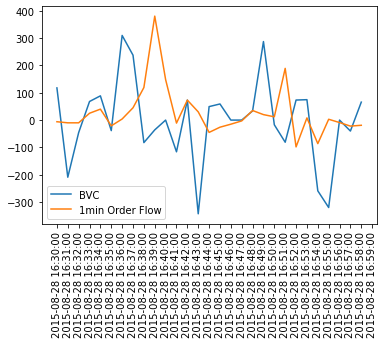

In [17]:
# Comparision of BVC and net order flow using agressor tag method over 30 minutes 
# Fifteen minutes are missing from the continuous data from 4:15-4:30pm so this shorter duration was warranted

timesteps = 30

labels = pv_bar_df['Time'][-timesteps:][pv_bar_df['Time'][-timesteps:].index]
labels.reset_index(drop=True, inplace=True)

plt.plot(filtered_pv_df, label='BVC')
plt.plot(filtered_agg_df['Orderflow'], label='1min Order Flow')
plt.legend()
plt.xticks(labels.index, labels, rotation=90);


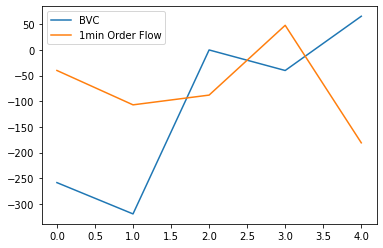

In [19]:
# Last five 1min bars of each dataset (4:55-5:00pm and 11:10-11:15pm)

last_five_df = aggregated_taq_df.loc[21][10:].reset_index(drop=True)

begin_min = 30
end_min = 59
timesteps = 30
label_spaces = 2

#labels.reset_index(drop=True, inplace=True)
#labels = labels[-6:]

plt.plot(filtered_pv_df[-5:].reset_index(drop=True), label='BVC')
plt.plot(last_five_df['Orderflow'], label= '1min Order Flow')
plt.legend();

In [51]:
# 15 minutes missing due to aggregation error 
hour_list =[]
min_list = []
counts = []
for hour, minute in list(aggregated_taq_df.index):
    min_list.append(minute)
    if hour not in hour_list:          
        hour_list.append(hour)
        
    if minute==59:
        
        counts.extend([[hour, len(min_list)]])
        min_list=[]
counts

[[0, 60],
 [1, 60],
 [2, 60],
 [3, 60],
 [4, 60],
 [5, 60],
 [6, 60],
 [7, 60],
 [8, 60],
 [9, 60],
 [10, 60],
 [11, 60],
 [12, 60],
 [13, 60],
 [14, 60],
 [15, 60],
 [16, 60],
 [17, 60],
 [18, 60],
 [19, 60],
 [20, 45]]

In [22]:
# 15 minutes missing between 4:15 and 4:30 pm due to aggregation error 
pv_bar_df['Time'][-32:]

973     2015-08-28 16:13:00
974     2015-08-28 16:14:00
975     2015-08-28 16:30:00
976     2015-08-28 16:31:00
977     2015-08-28 16:32:00
978     2015-08-28 16:33:00
979     2015-08-28 16:34:00
980     2015-08-28 16:35:00
981     2015-08-28 16:36:00
982     2015-08-28 16:37:00
983     2015-08-28 16:38:00
984     2015-08-28 16:39:00
985     2015-08-28 16:40:00
986     2015-08-28 16:41:00
987     2015-08-28 16:42:00
988     2015-08-28 16:43:00
989     2015-08-28 16:44:00
990     2015-08-28 16:45:00
991     2015-08-28 16:46:00
992     2015-08-28 16:47:00
993     2015-08-28 16:48:00
994     2015-08-28 16:49:00
995     2015-08-28 16:50:00
996     2015-08-28 16:51:00
997     2015-08-28 16:52:00
998     2015-08-28 16:53:00
999     2015-08-28 16:54:00
1000    2015-08-28 16:55:00
1001    2015-08-28 16:56:00
1002    2015-08-28 16:57:00
1003    2015-08-28 16:58:00
1004    2015-08-28 16:59:00
Name: Time, dtype: object

In [64]:
hour_list =[]
min_list = []
counts = []
for hour, minute in zip(pv_times.dt.hour, pv_times.dt.minute):
    min_list.append(minute)
    if hour not in hour_list:          
        hour_list.append(hour)
        
    if minute==59:
        
        counts.extend([[hour, len(min_list)]])
        min_list=[]
counts

[[0, 60],
 [1, 60],
 [2, 60],
 [3, 60],
 [4, 60],
 [5, 60],
 [6, 60],
 [7, 60],
 [8, 60],
 [9, 60],
 [10, 60],
 [11, 60],
 [12, 60],
 [13, 60],
 [14, 60],
 [15, 60],
 [16, 45]]

# Question 3
If we execute a trading strategy based on whether the order flow of the previous bar is positive or negative, what total P&L would you obtain based on this data? (Note: You can compute P&L based on the price-volume-bar data as an estimate.) (2 pt)

## Answer: 
Based on the direction in the discussion forum to use -1,0,1 instead of calculating a P&L,  I calculated the win-rate of a momentum and mean-reversion strategy.

Using t-1, I either assumed that t would either flip sign (mean reversion) or remain the same (momentum). I set the win column for each strategy to True if these predictions held. 
Only the tick data generated a strategy that was better than 50% (momentum).

In [24]:
aggregated_taq_df['Orderflow_Direction']=-3

aggregated_taq_df['Orderflow_Direction'].loc[:,aggregated_taq_df['Orderflow']>0]=1
aggregated_taq_df['Orderflow_Direction'].loc[:,aggregated_taq_df['Orderflow']<0]=-1
aggregated_taq_df['Orderflow_Direction'].loc[:,aggregated_taq_df['Orderflow']==0]=0
aggregated_taq_df['Mean_Reversion']=aggregated_taq_df['Orderflow_Direction'].shift(1)*-1
aggregated_taq_df['Momentum']=aggregated_taq_df['Orderflow_Direction'].shift(1)
aggregated_taq_df.dropna(thresh=2, axis=0,inplace=True)

aggregated_taq_df['Mean_Reversion_Win']=(aggregated_taq_df['Orderflow_Direction'])== (aggregated_taq_df['Mean_Reversion'])
aggregated_taq_df['Momentum_Win']=(aggregated_taq_df['Orderflow_Direction'])== (aggregated_taq_df['Momentum'])


# Win Rates
mean_rev = aggregated_taq_df['Mean_Reversion_Win'].sum()/len(aggregated_taq_df)
momentum_rev = aggregated_taq_df['Momentum_Win'].sum()/len(aggregated_taq_df)
print(f'Win rates:\nMean Reversion: {round(mean_rev *100, 1)}%\nMomentum: {round(momentum_rev*100, 1)}%')

Win rates:
Mean Reversion: 45.6%
Momentum: 53.3%


In [27]:
aggregated_taq_df['Cumsum_Orderflow'] = aggregated_taq_df['Orderflow'].cumsum()
aggregated_taq_df

Price  Orderflow  Volume  Orderflow_Direction  Mean_Reversion  \
Time Time                                                                    
0    0     1988.25       -117     431                   -1             NaN   
     1     1988.75        126     218                    1             1.0   
     2     1988.50        -21     145                   -1            -1.0   
     3     1988.75        -61     159                   -1             1.0   
     4     1988.75         12      30                    1             1.0   
...            ...        ...     ...                  ...             ...   
21   10    1986.75        -40     124                   -1             1.0   
     11    1986.50       -107     397                   -1             1.0   
     12    1986.00        -88     122                   -1             1.0   
     13    1986.25         48      74                    1             1.0   
     14    1986.25       -181     737                   -1            -1.0   

           Momentum  Mean_Reversion_Win  Momentum_Win  Cumsum_Orderflow  
Time Time                                                                
0    0          NaN               False         False              -117  
     1         -1.0                True         False                 9  
     2          1.0                True         False               -12  
     3         -1.0               False          True               -73  
     4         -1.0                True         False               -61  
...             ...                 ...           ...               ...  
21   10        -1.0               False          True            -24555  
     11        -1.0               False          True            -24662  
     12        -1.0               False          True            -24750  
     13        -1.0                True         False            -24702  
     14         1.0                True         False            -24883  

[1260 rows x 9 columns]

In [23]:
pv_bar_df['BVC_direction']=-3
pv_bar_df['BVC_direction'][pv_bar_df['BVC']<0]=-1
pv_bar_df['BVC_direction'][pv_bar_df['BVC']>0]= 1
pv_bar_df['BVC_direction'][pv_bar_df['BVC']==0]=0

pv_bar_df['Mean_Reversion']=pv_bar_df['BVC_direction'].shift(1)*-1
pv_bar_df['Momentum']=pv_bar_df['BVC_direction'].shift(1)
pv_bar_df.dropna(thresh=2, axis=0,inplace=True)

pv_bar_df['Mean_Reversion_Win']=(pv_bar_df['BVC_direction'])== (pv_bar_df['Mean_Reversion'])
pv_bar_df['Momentum_Win']=(pv_bar_df['BVC_direction'])== (pv_bar_df['Momentum'])

# Win Rates
mean_rev = pv_bar_df['Mean_Reversion_Win'].sum()/len(pv_bar_df)
momentum_rev = pv_bar_df['Momentum_Win'].sum()/len(pv_bar_df)
print(f'Win rates:\nMean Reversion: {round(mean_rev *100, 1)}%\nMomentum: {round(momentum_rev*100, 1)}%')

Win rates:
Mean Reversion: 43.6%
Momentum: 36.2%


In [28]:
pv_bar_df['Cumsum_BVC'] = pv_bar_df['BVC'].cumsum()
pv_bar_df

,Time,Open,High,Low,Close,Volume,delta_price,BVC,BVC_direction,Mean_Reversion,Momentum,Mean_Reversion_Win,Momentum_Win,Cumsum_BVC
3,2015-08-28 00:03:00,1.943308,1.943308,1.943063,1.943308,100,0.000000,0.000000,0,NaN,NaN,False,False,0.000000
4,2015-08-28 00:04:00,1.943308,1.943063,1.942572,1.942572,93,-0.000736,-92.999981,-1,-0.0,0.0,False,False,-92.999981
5,2015-08-28 00:05:00,1.942572,1.943063,1.942572,1.942818,92,0.000245,40.139337,1,1.0,-1.0,True,False,-52.860644
6,2015-08-28 00:06:00,1.942818,1.943063,1.942818,1.943063,50,0.000245,22.859877,1,-1.0,1.0,False,True,-30.000767
7,2015-08-28 00:07:00,1.943063,1.943063,1.942818,1.943063,43,0.000000,0.000000,0,-1.0,1.0,False,False,-30.000767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2015-08-28 16:55:00,1.951408,1.951408,1.950426,1.950426,363,-0.000982,-258.575518,-1,-1.0,1.0,True,False,53557.155520
1001,2015-08-28 16:56:00,1.950426,1.950426,1.949444,1.949690,556,-0.000736,-319.570173,-1,1.0,-1.0,False,True,53237.585347
1002,2015-08-28 16:57:00,1.949690,1.950180,1.949199,1.949690,539,0.000000,0.000000,0,1.0,-1.0,False,False,53237.585347
1003,2015-08-28 16:58:00,1.949690,1.949935,1.949444,1.949444,191,-0.000245,-40.060077,-1,-0.0,0.0,False,False,53197.525270
